In [53]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [54]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

In [55]:
device='cpu'

## Define target density

In [56]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [57]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [58]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

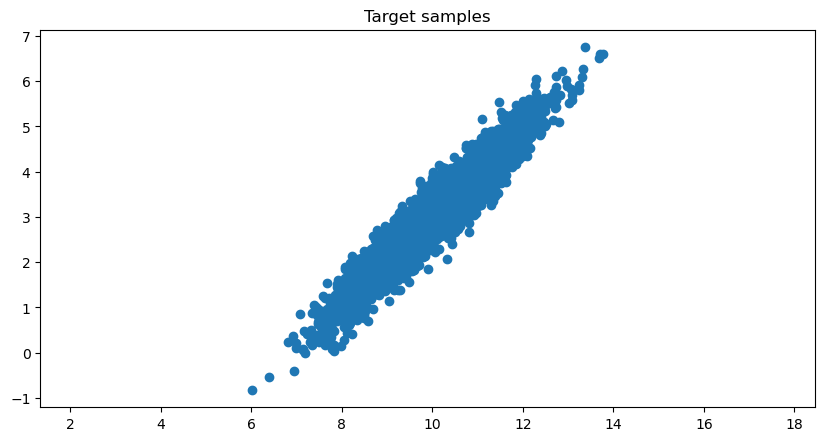

In [59]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [60]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [61]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [62]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  0%|▎                                                                             | 38/10000 [00:00<00:27, 367.40it/s]

Current value of KL at batch number 0 is 271.2528381347656


 11%|████████                                                                    | 1063/10000 [00:01<00:15, 587.80it/s]

Current value of KL at batch number 1000 is 18.376728057861328


 21%|███████████████▊                                                            | 2077/10000 [00:03<00:13, 584.91it/s]

Current value of KL at batch number 2000 is 9.955964088439941


 31%|███████████████████████▋                                                    | 3109/10000 [00:05<00:10, 640.44it/s]

Current value of KL at batch number 3000 is 3.7709672451019287


 41%|███████████████████████████████                                             | 4082/10000 [00:06<00:09, 657.30it/s]

Current value of KL at batch number 4000 is 1.5078442096710205


 51%|██████████████████████████████████████▉                                     | 5126/10000 [00:08<00:07, 622.36it/s]

Current value of KL at batch number 5000 is 1.2017052173614502


 61%|██████████████████████████████████████████████▍                             | 6109/10000 [00:10<00:06, 588.04it/s]

Current value of KL at batch number 6000 is 1.1487308740615845


 71%|█████████████████████████████████████████████████████▉                      | 7097/10000 [00:11<00:05, 568.44it/s]

Current value of KL at batch number 7000 is 1.1309880018234253


 80%|█████████████████████████████████████████████████████████████▏              | 8050/10000 [00:13<00:03, 526.64it/s]

Current value of KL at batch number 8000 is 1.1795974969863892


 91%|█████████████████████████████████████████████████████████████████████▎      | 9115/10000 [00:15<00:01, 547.75it/s]

Current value of KL at batch number 9000 is 1.132315754890442


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 576.77it/s]


### Plot both: samples from variational family and target

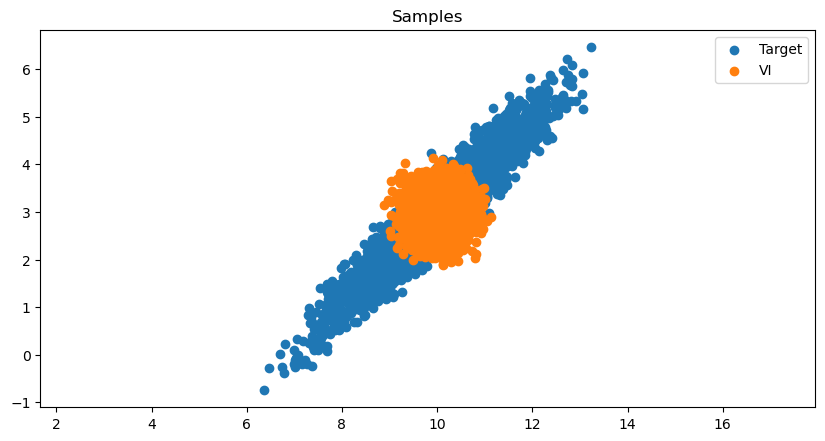

In [63]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## VI with GMM target

In [207]:
#### TODO: Добавь VI, таргетом для которого будет смесь двух гауссиан

class GMM():
    '''
    This class defines GMM (Gaussian Mixture Model) target (2d)
    '''
    def __init__(self, mus, covars):
        self.mus = mus
        self.covars = covars
        self.distr = torch.distributions.MixtureSameFamily(mus, covars)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, ))

In [208]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)

In [209]:
target_gmm = GMM(mix, comp)

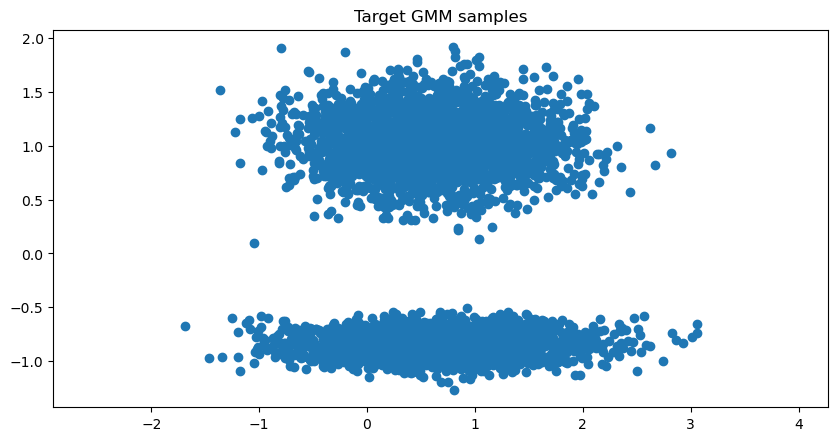

In [210]:
samples = target_gmm.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target GMM samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

In [211]:
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [212]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(std_param_raw)
    z = mu_param + u * std
    
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▎                                                                           | 177/10000 [00:00<00:11, 879.25it/s]

Current value of KL at batch number 0 is 7.259860992431641


 12%|████████▊                                                                   | 1164/10000 [00:01<00:10, 872.32it/s]

Current value of KL at batch number 1000 is 0.6940032243728638


 22%|████████████████▍                                                           | 2155/10000 [00:02<00:08, 898.24it/s]

Current value of KL at batch number 2000 is 0.6930743455886841


 32%|███████████████████████▉                                                    | 3156/10000 [00:03<00:07, 903.83it/s]

Current value of KL at batch number 3000 is 0.6928505897521973


 41%|███████████████████████████████▎                                            | 4128/10000 [00:04<00:06, 855.97it/s]

Current value of KL at batch number 4000 is 0.6941955089569092


 52%|███████████████████████████████████████▍                                    | 5192/10000 [00:05<00:05, 864.36it/s]

Current value of KL at batch number 5000 is 0.6930158138275146


 62%|██████████████████████████████████████████████▊                             | 6162/10000 [00:07<00:04, 886.64it/s]

Current value of KL at batch number 6000 is 0.6944884061813354


 71%|██████████████████████████████████████████████████████▎                     | 7139/10000 [00:08<00:03, 850.99it/s]

Current value of KL at batch number 7000 is 0.6931146383285522


 81%|█████████████████████████████████████████████████████████████▋              | 8121/10000 [00:09<00:02, 886.91it/s]

Current value of KL at batch number 8000 is 0.6937808990478516


 92%|█████████████████████████████████████████████████████████████████████▉      | 9195/10000 [00:10<00:00, 873.94it/s]

Current value of KL at batch number 9000 is 0.6934711933135986


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 867.39it/s]


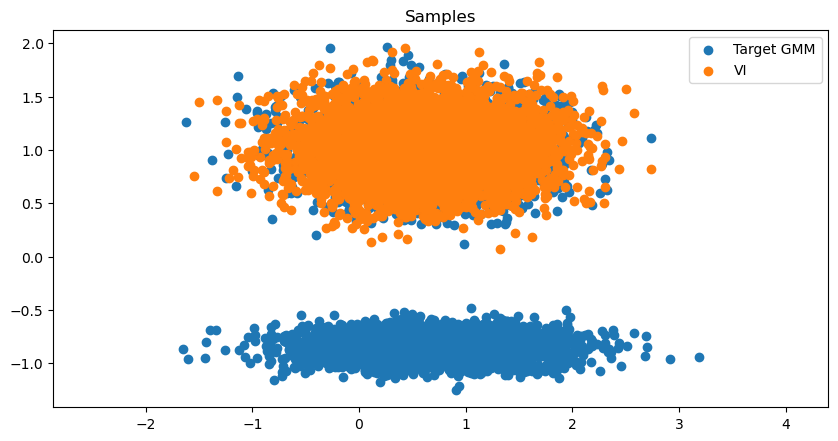

In [213]:
N = 5000

u = std_normal.sample((N, 2))
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## Approximating a mixture of Gaussians

In [214]:
mus_param = nn.Parameter(torch.tensor([[0., 0.],[1., 1.]], device=device, dtype=torch.float32))

stds_param_raw = nn.Parameter(torch.tensor([[0., 0.],[0., 0.]], device=device, dtype=torch.float32))

pi = nn.Parameter(torch.tensor(0.5, device=device, dtype=torch.float32))

optimizer = torch.optim.Adam(params=[mus_param, stds_param_raw, pi], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal1 = torch.distributions.Normal(loc=mus_param[0],
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
std_normal2 = torch.distributions.Normal(loc=mus_param[1],
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

#mix = torch.distributions.Categorical(pi)
#comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)
#std_normal_mix = torch.distributions.MixtureSameFamily(mix, comp)

In [215]:
for i in tqdm(range(num_batches)):
    u = pi * std_normal1.sample((batch_size, 2)) + (1 - pi) * std_normal2.sample((batch_size, 2))
    
    std = torch.exp(stds_param_raw)
    z = mus_param + u * std
   
    KL = -torch.sum(stds_param_raw) + pi * std_normal1.log_prob(u).sum(1).mean() + \
    (1 - pi) * std_normal2.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  1%|▌                                                                             | 74/10000 [00:00<00:27, 366.62it/s]

Current value of KL at batch number 0 is 3.759903907775879


 11%|████████                                                                    | 1067/10000 [00:02<00:23, 381.34it/s]

Current value of KL at batch number 1000 is 1.2497882843017578


 20%|███████████████▌                                                            | 2046/10000 [00:05<00:21, 373.66it/s]

Current value of KL at batch number 2000 is 1.1863512992858887


 31%|███████████████████████▎                                                    | 3068/10000 [00:08<00:17, 394.28it/s]

Current value of KL at batch number 3000 is 1.2345690727233887


 41%|██████████████████████████████▉                                             | 4063/10000 [00:10<00:15, 394.58it/s]

Current value of KL at batch number 4000 is 1.2509456872940063


 51%|██████████████████████████████████████▌                                     | 5068/10000 [00:13<00:12, 395.03it/s]

Current value of KL at batch number 5000 is 1.2056758403778076


 61%|██████████████████████████████████████████████                              | 6068/10000 [00:15<00:10, 389.10it/s]

Current value of KL at batch number 6000 is 1.191056251525879


 71%|█████████████████████████████████████████████████████▋                      | 7062/10000 [00:18<00:07, 390.21it/s]

Current value of KL at batch number 7000 is 1.250504970550537


 81%|█████████████████████████████████████████████████████████████▎              | 8063/10000 [00:20<00:04, 397.62it/s]

Current value of KL at batch number 8000 is 1.226778507232666


 91%|████████████████████████████████████████████████████████████████████▉       | 9069/10000 [00:23<00:02, 397.67it/s]

Current value of KL at batch number 9000 is 1.2198172807693481


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.88it/s]


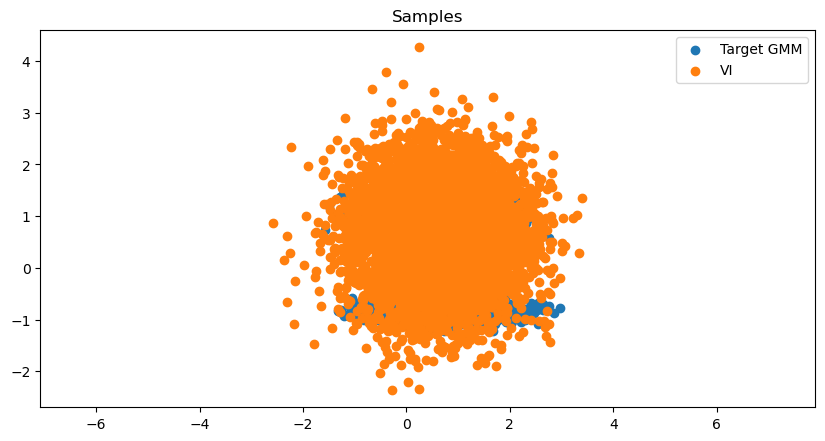

In [216]:
N = 5000

u = pi * std_normal1.sample((N,2)) + (1 - pi) * std_normal2.sample((N,2))
with torch.no_grad():
    std = torch.exp(stds_param_raw)
    sample_varfamily = mus_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();